# Front-Illuminated FVC Images

MUST BE RUN ON JAX-TEST KERNEL

In [1]:
%matplotlib inline

In [2]:
import os

In [3]:
import pathlib

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import fitsio

In [6]:
import fpoffline.fvc

Lists of the available large image stacks, indexed by night, from [here](https://desi.lbl.gov/trac/wiki/FPS/FrontIlluminatedImage):

In [7]:
stacks = {
    20210610: list(range(93175, 93245)),
    20220111: list(range(118046, 118146)),
    20220113: list(range(118532, 118632)),
}

Create full-depth coadds for each stack:

In [8]:
def stack_fvc(path, expids, ext='F0000', verbose=True):
    path = pathlib.Path(path)
    if not path.exists():
        raise ValueError('Invalid path: {path}')
    stack = np.zeros((6000,6000), np.float32)
    tot_exptime = 0
    for expid in expids:
        exptag = str(expid).zfill(8)
        filename = path / exptag / f'fvc-{exptag}.fits.fz'
        if not filename.exists():
            raise ValueError('Missing file: {filename}')
        hdr = fitsio.read_header(str(filename), ext=ext)
        tot_exptime += hdr.get('EXPTIME', 0)
        data = fitsio.read(str(filename), ext=ext)
        stack += data
    if verbose:
        print(f'Stacked {tot_exptime:.1f}s from {len(expids)} exposures.')
    return stack

In [9]:
DESI = pathlib.Path('/global/cfs/cdirs/desi')
DATA = DESI /  'spectro' / 'data'
assert DATA.exists()

In [10]:
coadds = { night: fpoffline.fvc.process_front_illuminated(stack_fvc(DATA / str(night), expids)) for night,expids in stacks.items() }

Stacked 700.0s from 70 exposures.
Stacked 1000.0s from 100 exposures.
Stacked 1000.0s from 100 exposures.


Generate random training data:

In [11]:
# def generate(ngen, size=3000, seed=123):
    
#     nights = np.array(list(stacks.keys()))
#     data = np.empty((2, ngen, size, size), np.float32)
#     fullsize = 6000

#     # Pick a random night and exposure for each sample.
#     rng = np.random.RandomState(seed)
#     inights = rng.choice(len(nights), ngen, replace=True)
#     expids = np.array([rng.choice(stacks[nights[i]], 1)[0] for i in inights])

#     # Loop over nights used in sample.
#     for inight in np.unique(inights):
#         night = nights[inight]
#         night_idx = np.where(inights == inight)[0]
#         # Get the coadd for this night.
#         coadd = coadds[night]
#         # Loop over exposures from this night used in the sample.
#         night_expids = expids[night_idx]        
#         for expid in np.unique(night_expids):
#             exp_idx = np.where(night_expids == expid)[0]
#             igens = night_idx[exp_idx]
#             # Read this single exposure.
#             exptag = str(expid).zfill(8)
#             filename = DATA / str(night) / exptag / f'fvc-{exptag}.fits.fz'
#             print(night, expid, igens, filename)
#             single = fpoffline.fvc.process_front_illuminated(fitsio.read(str(filename), ext='F0000'))
#             for igen in igens:
#                 # Generate random size x size subimage.
#                 x1 = rng.randint(fullsize - size)
#                 y1 = rng.randint(fullsize - size)
#                 S = (slice(y1, y1 + size), slice(x1, x1 + size))
#                 # training input
#                 data[0,igen] = single[S]
#                 # target output
#                 data[1,igen] = coadd[S]
#     return data

# D = generate(1500)

def generate(ngen, size=6000, seed=123):
    
    nights = np.array(list(stacks.keys()))
    data = np.empty((2, ngen, size, size), np.float32)
    fullsize = 6000

    # Pick a random night and exposure for each sample.
    rng = np.random.RandomState(seed)
    inights = rng.choice(len(nights), ngen, replace=True)
    expids = np.array([rng.choice(stacks[nights[i]], 1)[0] for i in inights])

    # Loop over nights used in sample.
    for inight in np.unique(inights):
        night = nights[inight]
        night_idx = np.where(inights == inight)[0]
        # Get the coadd for this night.
        coadd = coadds[night]
        # Loop over exposures from this night used in the sample.
        night_expids = expids[night_idx]        
        for expid in np.unique(night_expids):
            exp_idx = np.where(night_expids == expid)[0]
            igens = night_idx[exp_idx]
            # Read this single exposure.
            exptag = str(expid).zfill(8)
            filename = DATA / str(night) / exptag / f'fvc-{exptag}.fits.fz'
            print(night, expid, igens, filename)
            single = fpoffline.fvc.process_front_illuminated(fitsio.read(str(filename), ext='F0000'))
            for igen in igens:
                # # # Generate random size x size subimage.
                # x1 = rng.randint(fullsize - size)
                # y1 = rng.randint(fullsize - size)
                # S = (slice(y1, y1 + size), slice(x1, x1 + size))
                # training input
                data[0,igen] = single
                # target output
                data[1,igen] = coadd
    return data

D = generate(600)

20210610 93175 [419] /global/cfs/cdirs/desi/spectro/data/20210610/00093175/fvc-00093175.fits.fz
20210610 93176 [ 85 123 398] /global/cfs/cdirs/desi/spectro/data/20210610/00093176/fvc-00093176.fits.fz
20210610 93177 [526 572] /global/cfs/cdirs/desi/spectro/data/20210610/00093177/fvc-00093177.fits.fz
20210610 93178 [84] /global/cfs/cdirs/desi/spectro/data/20210610/00093178/fvc-00093178.fits.fz
20210610 93179 [ 56 321 381] /global/cfs/cdirs/desi/spectro/data/20210610/00093179/fvc-00093179.fits.fz
20210610 93180 [ 18  37 570] /global/cfs/cdirs/desi/spectro/data/20210610/00093180/fvc-00093180.fits.fz
20210610 93182 [349 458 487] /global/cfs/cdirs/desi/spectro/data/20210610/00093182/fvc-00093182.fits.fz
20210610 93183 [127 334 599] /global/cfs/cdirs/desi/spectro/data/20210610/00093183/fvc-00093183.fits.fz
20210610 93184 [165 524] /global/cfs/cdirs/desi/spectro/data/20210610/00093184/fvc-00093184.fits.fz
20210610 93185 [207] /global/cfs/cdirs/desi/spectro/data/20210610/00093185/fvc-00093185.f

In [12]:
def show(igen):
    train = D[0, igen]
    target = D[1, igen]
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(train, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[1].imshow(target, origin='lower', interpolation='none')
    ax[1].axis('off')

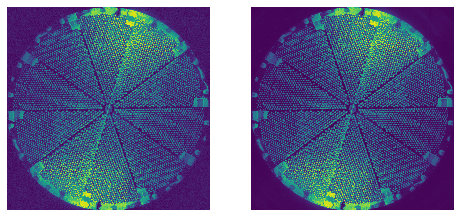

In [13]:
show(60)

In [14]:
current_dir = pathlib.Path().resolve()
PLANE_data_path = current_dir / 'Data'
assert PLANE_data_path.exists()

In [15]:
def save(data, name):
    np.save(PLANE_data_path / name, data)

In [16]:
save(D, 'data600-6000.npy')